In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from time import sleep
import pandas as pd
from io import StringIO
from functools import partial
import matplotlib.pyplot as plt
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common import NoSuchElementException,StaleElementReferenceException
from matplotlib import style
from webdriver_manager.chrome import ChromeDriverManager
import re
import numpy as np

In [2]:
print(plt.style.available)
%matplotlib inline
driver = webdriver.Edge()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## 1.二手房房价

In [3]:
url='https://esf.fang.com/house-a015277-b05/i31/'
driver.get(url)

In [4]:
total_price_data=[]
unit_price_data=[]
area_data=[]
for i in range(4):
    #找到父容器，避免提取无关span（这里没用上）
    #container = driver.find_element('class name', 'shop_list')
    #spans = container.find_elements('class name','red')
    total_price_spans=driver.find_elements('class name','red')
    
    # Initialize lists to store data
    total_price_data_currentpage=[]
    
    # Loop through spans and extract data
    for index,span in enumerate(total_price_spans):
        span_text=span.text
        total_price_data_currentpage.append(span_text)
    #list.extend()是原地操作（直接修改原列表，没有返回值，默认返回 None）
    #错误操作：price_data=price_data.extend(price_data_currentpage)
    total_price_data.extend(total_price_data_currentpage)

    unit_price_spans=driver.find_elements(By.XPATH, "//dd[@class='price_right']/span[2]")
    unit_price_data_currentpage=[]
    for index,span in enumerate(unit_price_spans):
        span_text=span.text
        unit_price_data_currentpage.append(span_text)
    unit_price_data.extend(unit_price_data_currentpage)
    
    area_spans=driver.find_elements('class name','tel_shop')
    area_data_currentpage=[]
    for index,span in enumerate(area_spans):
        span_text=span.text
        #筛选需要信息
        all_parts=span_text.split()
        area_text=all_parts[2]
        area_data_currentpage.append(area_text)
    area_data.extend(area_data_currentpage)
    
    #找到翻页标并翻页
    try:
        next_page=driver.find_element('class name','last')
        next_page.click()
    except NoSuchElementException:
        print("NoSuchElementException")

price_df = pd.DataFrame(
    {'total_price':total_price_data,
     'unit_price':unit_price_data,
     'area':area_data
    })

In [5]:
price_df

,total_price,unit_price,area
0,598万,73763元/㎡,81.07㎡
1,760万,81292元/㎡,93.49㎡
2,286万,86274元/㎡,33.15㎡
3,498万,78922元/㎡,63.1㎡
4,750万,90678元/㎡,82.71㎡
...,...,...,...
190,890万,97695元/㎡,91.1㎡
191,1600万,120537元/㎡,132.74㎡
192,2580万,120804元/㎡,213.57㎡
193,630万,80358元/㎡,78.4㎡


In [6]:
#正则表达式提取纯数字
# 定义函数：提取字符串中的数字并转为 float
def extract_number_1(s):
    # 正则匹配数字（支持整数和小数）
    match = re.search(r'(\d+\.?\d*)', s)
    if match:
        return float(match.group())
    return None  # 无数字时返回 None
def extract_number_2(s):
    match = re.search(r'(\d+\.?\d*)', s)
    if match:
        number=float(match.group())
        number=number*10000
        return number
    return None  # 无数字时返回 None

# 对每一列应用提取函数
price_df_new=pd.DataFrame()
price_df_new['total_price'] = price_df['total_price'].apply(extract_number_2)
price_df_new['unit_price'] = price_df['unit_price'].apply(extract_number_1)
price_df_new['area'] = price_df['area'].apply(extract_number_1)

price_df_new

,total_price,unit_price,area
0,5980000.0,73763.0,81.07
1,7600000.0,81292.0,93.49
2,2860000.0,86274.0,33.15
3,4980000.0,78922.0,63.10
4,7500000.0,90678.0,82.71
...,...,...,...
190,8900000.0,97695.0,91.10
191,16000000.0,120537.0,132.74
192,25800000.0,120804.0,213.57
193,6300000.0,80358.0,78.40


## 2.租房房价

In [7]:
url='https://zu.fang.com/house-a015277-b05/'
driver.get(url)

In [8]:
total_price_data=[]
area_data=[]
for i in range(5):
    total_price_spans=driver.find_elements('class name','moreInfo')
    total_price_data_currentpage=[]
    for index,span in enumerate(total_price_spans):
        span_text=span.text
        total_price_data_currentpage.append(span_text)
    total_price_data.extend(total_price_data_currentpage)
    
    area_spans=driver.find_elements('class name','font15')
    area_data_currentpage=[]
    for index,span in enumerate(area_spans):
        span_text=span.text
        #筛选信息
        area_text = None
        for part in span_text.split('|'):  # 按空格分割文本为多个片段
            if "㎡" in part:
                area_text = part
                break
        area_data_currentpage.append(area_text)
    area_data.extend(area_data_currentpage)
    
    #找到翻页标并翻页
    try:
        next_page=driver.find_element(By.LINK_TEXT,'下一页')
        next_page.click()
    except NoSuchElementException:
        print("NoSuchElementException")

rent_price_df = pd.DataFrame({
    'total_rent_price':total_price_data,
    'area':area_data
    })

NoSuchElementException


In [9]:
rent_price_df

,total_rent_price,area
0,2550元/月,20㎡
1,2650元/月,20㎡
2,6300元/月,60㎡
3,7400元/月,53㎡
4,1700元/月,10㎡
...,...,...
238,11000元/月,78㎡
239,3050元/月,15㎡
240,7000元/月,47㎡
241,6800元/月,50㎡


In [10]:
#正则表达式提取纯数字
# 定义函数：提取字符串中的数字并转为 float
def extract_number(s):
    # 正则匹配数字（支持整数和小数）
    match = re.search(r'(\d+\.?\d*)', s)
    if match:
        return float(match.group())
    return None  # 无数字时返回 None

# 对每一列应用提取函数
rent_price_df_new=pd.DataFrame()
rent_price_df_new['total_rent_price'] = rent_price_df['total_rent_price'].apply(extract_number)
rent_price_df_new['area'] = rent_price_df['area'].apply(extract_number)

rent_price_df_new

,total_rent_price,area
0,2550.0,20.0
1,2650.0,20.0
2,6300.0,60.0
3,7400.0,53.0
4,1700.0,10.0
...,...,...
238,11000.0,78.0
239,3050.0,15.0
240,7000.0,47.0
241,6800.0,50.0


In [11]:
#保存文件(CSV形式）
download_path_1 = r'C:\Users\lenovo\Desktop\北太平庄二手房价.csv'
download_path_2 = r'C:\Users\lenovo\Desktop\北太平庄租房房价.csv'
price_df_new.to_csv(download_path_1, index=False)
rent_price_df_new.to_csv(download_path_2, index=False)

In [12]:
#保存文件(xlsx形式）
#download_path_1 = r'C:\Users\lenovo\Desktop\北太平庄二手房价.xlsx'
#download_path_2 = r'C:\Users\lenovo\Desktop\北太平庄租房房价.xlsx'
#price_df_new.to_excel(download_path_1, index=False)
#rent_price_df_new.to_excel(download_path_2, index=False)

In [13]:
BTPZ_price_df=price_df_new.copy()
BTPZ_price_df['lo_SZQ']=0
BTPZ_price_df['lo_WL']=0
BTPZ_price_df['lo_BTPZ']=1
BTPZ_price_df['lo_SJC']=0
#calculate unit_price
BTPZ_rent_df=rent_price_df_new.copy()
BTPZ_rent_df['unit_rent'] = BTPZ_rent_df['total_rent_price']/BTPZ_rent_df['area']
BTPZ_rent_df['lo_SZQ']=0
BTPZ_rent_df['lo_WL']=0
BTPZ_rent_df['lo_BTPZ']=1
BTPZ_rent_df['lo_SJC']=0

BTPZ_rent_df.head()

,total_rent_price,area,unit_rent,lo_SZQ,lo_WL,lo_BTPZ,lo_SJC
0,2550.0,20.0,127.500000,0,0,1,0
1,2650.0,20.0,132.500000,0,0,1,0
2,6300.0,60.0,105.000000,0,0,1,0
3,7400.0,53.0,139.622642,0,0,1,0
4,1700.0,10.0,170.000000,0,0,1,0


## 3.整理数据

In [14]:
#导入数据表
SZQ_price_df=pd.read_csv('SZQprices.csv')
WL_price_df=pd.read_csv('WLprices.csv')
SJC_price_df=pd.read_excel('SJCprices.xlsx')
SZQ_rent_df=pd.read_csv('SZQrents.csv')
WL_rent_df=pd.read_csv('WLrents.csv')
SJC_rent_df=pd.read_excel('SJCrents.xlsx')

In [15]:
#SZQ
SZQ_price_df['lo_SZQ']=1
SZQ_price_df['lo_WL']=0
SZQ_price_df['lo_BTPZ']=0
SZQ_price_df['lo_SJC']=0
SZQ_rent_df['lo_SZQ']=1
SZQ_rent_df['lo_WL']=0
SZQ_rent_df['lo_BTPZ']=0
SZQ_rent_df['lo_SJC']=0
#WL
WL_price_df['lo_SZQ']=0
WL_price_df['lo_WL']=1
WL_price_df['lo_BTPZ']=0
WL_price_df['lo_SJC']=0
WL_rent_df['lo_SZQ']=0
WL_rent_df['lo_WL']=1
WL_rent_df['lo_BTPZ']=0
WL_rent_df['lo_SJC']=0
#SJC
SJC_price_df['lo_SZQ']=0
SJC_price_df['lo_WL']=0
SJC_price_df['lo_BTPZ']=0
SJC_price_df['lo_SJC']=1
SJC_rent_df['lo_SZQ']=0
SJC_rent_df['lo_WL']=0
SJC_rent_df['lo_BTPZ']=0
SJC_rent_df['lo_SJC']=1

In [16]:
#merge dataframes
price_df = pd.concat(
    [SZQ_price_df,WL_price_df,BTPZ_price_df,SJC_price_df],  # 传入包含所有DataFrame的列表
    ignore_index=True      # 重置索引，避免重复
)
rent_df = pd.concat(
    [SZQ_rent_df,WL_rent_df,BTPZ_rent_df,SJC_rent_df],
    ignore_index=True
)

In [17]:
price_df.head()

,total_price,unit_price,area,lo_SZQ,lo_WL,lo_BTPZ,lo_SJC
0,7200000.0,78878.0,91.28,1,0,0,0
1,3980000.0,70194.0,56.70,1,0,0,0
2,4800000.0,81771.0,58.70,1,0,0,0
3,3550000.0,62280.0,57.00,1,0,0,0
4,3980000.0,70194.0,56.70,1,0,0,0


In [18]:
rent_df.head()

,total_rent_price,area,unit_rent,lo_SZQ,lo_WL,lo_BTPZ,lo_SJC
0,10200.0,66.0,154.545455,1,0,0,0
1,15000.0,74.0,202.702703,1,0,0,0
2,12500.0,85.0,147.058823,1,0,0,0
3,9500.0,58.0,163.793103,1,0,0,0
4,9500.0,58.0,163.793103,1,0,0,0


## 4.Figure A

In [19]:
def mid_price_to_rent(prices,rents):
    mid_price=np.median(prices)
    mid_rent=np.median(rents)
    price_to_rent=mid_price/mid_rent
    return price_to_rent

SZQ_mid=mid_price_to_rent(SZQ_price_df['unit_price'],SZQ_rent_df['unit_rent'])
WL_mid=mid_price_to_rent(WL_price_df['unit_price'],WL_rent_df['unit_rent'])
BTPZ_mid=mid_price_to_rent(BTPZ_price_df['unit_price'],BTPZ_rent_df['unit_rent'])
SJC_mid=mid_price_to_rent(SJC_price_df['unit_price'],SJC_rent_df['unit_rent'])

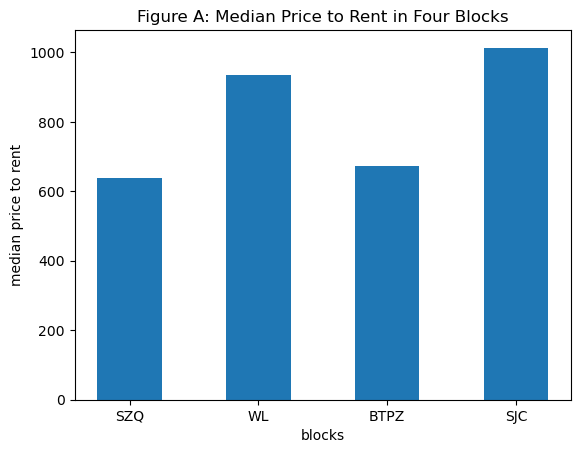

In [20]:
#bar plot
x = np.arange(4)  # 柱状图的x轴位置，这里生成0-3共4个位置
labels = ['SZQ', 'WL', 'BTPZ', 'SJC']
height = [SZQ_mid,WL_mid,BTPZ_mid,SJC_mid]  # 每个柱子的高度
# 绘制柱状图
plt.bar(x, height, width=0.5)  # width表示柱子的宽度
plt.xticks(x, labels)
# 添加标题和轴标签
plt.title('Figure A: Median Price to Rent in Four Blocks')
plt.xlabel('blocks')
plt.ylabel('median price to rent')

# 显示图形
plt.show()

## 5.Figure B

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
def regression(X,y,df,X1,X2,X3,X4,df1,df2,df3,df4):
    # 训练线性回归模型
    model = LinearRegression()
    model.fit(X, y)
    # 生成预测值
    df1['pred'] = model.predict(X1)
    df2['pred'] = model.predict(X2)
    df3['pred'] = model.predict(X3)
    df4['pred'] = model.predict(X4)
    return df1,df2,df3,df4

In [23]:
#model 1
df=price_df.copy()
df1=SZQ_price_df.copy()
df2=WL_price_df.copy()
df3=BTPZ_price_df.copy()
df4=SJC_price_df.copy()
X=df[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]  # 特征变量
y=df['unit_price']  # 目标变量
X1=df1[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]
X2=df2[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]
X3=df3[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]
X4=df4[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]

SZQ_price_df_B,WL_price_df_B,BTPZ_price_df_B,SJC_price_df_B=regression(X,y,df,X1,X2,X3,X4,df1,df2,df3,df4)

#model 2
df=rent_df.copy()
df1=SZQ_rent_df.copy()
df2=WL_rent_df.copy()
df3=BTPZ_rent_df.copy()
df4=SJC_rent_df.copy()
X=df[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]  # 特征变量
y=df['unit_rent']  # 目标变量
X1=df1[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]
X2=df2[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]
X3=df3[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]
X4=df4[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC']]

SZQ_rent_df_B,WL_rent_df_B,BTPZ_rent_df_B,SJC_rent_df_B=regression(X,y,df,X1,X2,X3,X4,df1,df2,df3,df4)

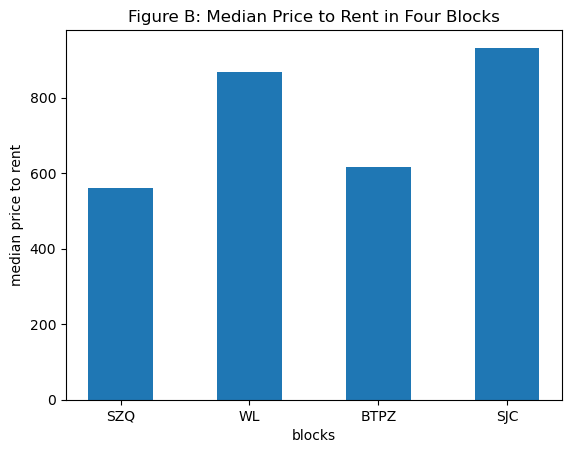

In [24]:
SZQ_mid=mid_price_to_rent(SZQ_price_df_B['pred'],SZQ_rent_df_B['pred'])
WL_mid=mid_price_to_rent(WL_price_df_B['pred'],WL_rent_df_B['pred'])
BTPZ_mid=mid_price_to_rent(BTPZ_price_df_B['pred'],BTPZ_rent_df_B['unit_rent'])
SJC_mid=mid_price_to_rent(SJC_price_df_B['pred'],SJC_rent_df_B['pred'])

#bar plot
x = np.arange(4)  # 柱状图的x轴位置，这里生成0-3共4个位置
labels = ['SZQ', 'WL', 'BTPZ', 'SJC']
height = [SZQ_mid,WL_mid,BTPZ_mid,SJC_mid]  # 每个柱子的高度
# 绘制柱状图
plt.bar(x, height, width=0.5)  # width表示柱子的宽度
plt.xticks(x, labels)
# 添加标题和轴标签
plt.title('Figure B: Median Price to Rent in Four Blocks')
plt.xlabel('blocks')
plt.ylabel('median price to rent')

# 显示图形
plt.show()

## 6.Figure c

In [25]:
def add_inter(df):
    df['area*lo_SZQ']=df['area']*df['lo_SZQ']
    df['area*lo_WL']=df['area']*df['lo_WL']
    df['area*lo_BTPZ']=df['area']*df['lo_BTPZ']
    df['area*lo_SJC']=df['area']*df['lo_SJC']
    return df

In [29]:
#model 1+
df=price_df.copy()
df1=SZQ_price_df.copy()
df2=WL_price_df.copy()
df3=BTPZ_price_df.copy()
df4=SJC_price_df.copy()

df=add_inter(df)
df1=add_inter(df1)
df2=add_inter(df2)
df3=add_inter(df3)
df4=add_inter(df4)

X=df[['area','lo_SZQ','lo_WL','lo_BTPZ','lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]  # 特征变量
y=df['unit_price']  # 目标变量
X1=df1[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]
X2=df2[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]
X3=df3[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]
X4=df4[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]

SZQ_price_df_C,WL_price_df_C,BTPZ_price_df_C,SJC_price_df_C=regression(X,y,df,X1,X2,X3,X4,df1,df2,df3,df4)

#model 2+
df=rent_df.copy()
df1=SZQ_rent_df.copy()
df2=WL_rent_df.copy()
df3=BTPZ_rent_df.copy()
df4=SJC_rent_df.copy()

df=add_inter(df)
df1=add_inter(df1)
df2=add_inter(df2)
df3=add_inter(df3)
df4=add_inter(df4)

X=df[['area','lo_SZQ','lo_WL','lo_BTPZ','lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]  # 特征变量
y=df['unit_rent']  # 目标变量
X1=df1[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]
X2=df2[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]
X3=df3[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]
X4=df4[['area', 'lo_SZQ', 'lo_WL', 'lo_BTPZ', 'lo_SJC','area*lo_SZQ','area*lo_WL','area*lo_BTPZ','area*lo_SJC']]

SZQ_rent_df_C,WL_rent_df_C,BTPZ_rent_df_C,SJC_rent_df_C=regression(X,y,df,X1,X2,X3,X4,df1,df2,df3,df4)

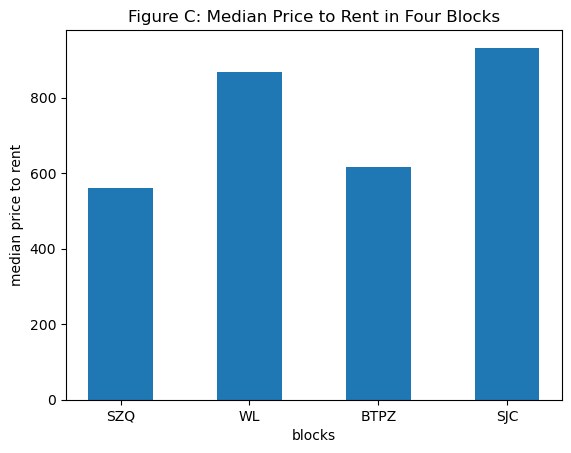

In [30]:
SZQ_mid=mid_price_to_rent(SZQ_price_df_B['pred'],SZQ_rent_df_B['pred'])
WL_mid=mid_price_to_rent(WL_price_df_B['pred'],WL_rent_df_B['pred'])
BTPZ_mid=mid_price_to_rent(BTPZ_price_df_B['pred'],BTPZ_rent_df_B['unit_rent'])
SJC_mid=mid_price_to_rent(SJC_price_df_B['pred'],SJC_rent_df_B['pred'])

#bar plot
x = np.arange(4)  # 柱状图的x轴位置，这里生成0-3共4个位置
labels = ['SZQ', 'WL', 'BTPZ', 'SJC']
height = [SZQ_mid,WL_mid,BTPZ_mid,SJC_mid]  # 每个柱子的高度
# 绘制柱状图
plt.bar(x, height, width=0.5)  # width表示柱子的宽度
plt.xticks(x, labels)
# 添加标题和轴标签
plt.title('Figure C: Median Price to Rent in Four Blocks')
plt.xlabel('blocks')
plt.ylabel('median price to rent')

# 显示图形
plt.show()